In [1]:
import pywt
import numpy as np
from numpy.fft import fft2,ifft2
from  scipy.signal import wiener
from scipy.io import loadmat
import pandas


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

#exp1=np.loadtxt('sttest1.txt')
#noobj20082018=np.loadtxt('noobject.txt')
data_folders='images/'
exp1=np.load(data_folders+'sttest1.npy')
noobj20082018=np.load(data_folders+'noobject.npy')

A=exp1[:512,:640]
B=exp1[:512,640:1280]

M=noobj20082018[:512,:640]
N=noobj20082018[:512,640:1280]

L=A/M
H=B/N


concatenated L&H image, noobject image


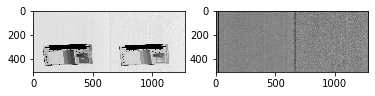

In [3]:
print('concatenated L&H image, noobject image')

plt.subplot(1,2,1)
plt.imshow(exp1,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(noobj20082018,cmap='gray')

L and H images


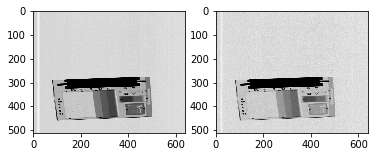

In [4]:
print('L and H images')
plt.subplot(1,2,1)
plt.imshow(L,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(H,cmap='gray')

In [5]:
LE=0.5*L**3.8
HE=0.6*H**0.2
a1,(h1,v1,d1)=pywt.dwt2(LE,'haar')
a2,(h2,v2,d2)=pywt.dwt2(HE,'haar')

k1,k2=a1.shape
ahvd3=(a1+a2,(h1+h2,v1+v2,d1+d2))

c=pywt.idwt2(ahvd3,'haar')
f=(((c-c.min())/(c.max()-c.min()))*255).astype(np.uint8)#normalize and rescale



Fused image


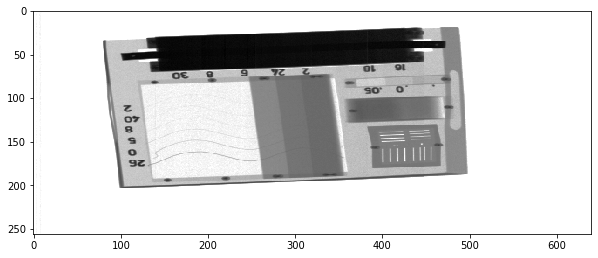

In [6]:
print('Fused image')
f=np.clip(c,0,1)
plt.figure(figsize=(10,10))
plt.imshow(f[256:,:],cmap='gray')

In [7]:
f=(f*255).astype(np.uint8)
print('Number of unique values in the fused image',len(np.unique(f)))

Number of unique values in the fused image 209


In [8]:
L1=wiener(L,[5,5])
H1=wiener(H,[5,5])

imfused=f
le=LE
he=HE
if le.size==he.size and le.size==imfused.size:
    print("LE and HE have equal sizes")
else:
    he=imresize(he,size(le))
    imfused=imresize(imfused,size(le))
    print('LE and HE now have same sizes')


LE and HE have equal sizes


In [9]:
x_ax=(L1+H1)/2
#x_ax=x_ax.flatten()
y_ax=H1-L1
#y_ax=y_ax.flatten()

#y_s=9.6275*np.power(x_ax,7)-32.087*np.power(x_ax,6)+42.001*np.power(x_ax,5)-27.569*np.power(x_ax,4)+9.7762*np.power(x_ax,3)-3.077*np.power(x_ax,2)+1.3534*x_ax-0.0037905
#y_al=-38.88*np.power(x_ax,8)+154.27*np.power(x_ax,7)-250.09*np.power(x_ax,6)+213.27*np.power(x_ax,5)-103.09*np.power(x_ax,4)+28.698*np.power(x_ax,3)-5.2513*np.power(x_ax,2)+1.0521*x_ax-0.0023044;
#y_p=-517.83*np.power(x_ax,10)+2470.8*np.power(x_ax,9)-5016.5*np.power(x_ax,8)+5652.2*np.power(x_ax,7)-3864.3*np.power(x_ax,6)+1647*np.power(x_ax,5)-433.65*np.power(x_ax,4)+68.218*np.power(x_ax,3)-6.5501*np.power(x_ax,2)+0.59162*x_ax-0.00034462;

y_s=-1.2*(x_ax**2)+1.16*x_ax-0.002;
y_p=-0.21*(x_ax**2)+0.16*x_ax+0.018;
y_al=-0.65*(x_ax**2)+0.68*x_ax+0.0074;

y_a=(y_p+y_al)/2;
y_b=(y_al+y_s)/2;


In [10]:
choice_v1=np.zeros(y_ax.shape)
choice_v1[y_ax>y_b]=1
choice_v1[y_ax<y_a]=3
choice_v1[choice_v1==0]=2
choice_v1[np.logical_and(x_ax<0.06, y_ax<0.06)]=1
#re=np.zeros()
res=np.zeros((y_ax.size,1,3))
choice_v1=(choice_v1-1).astype(np.uint8)
print('choice matrix sample, unique, shape',choice_v1,np.unique(choice_v1),choice_v1.shape)

choice matrix sample, unique, shape [[2 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 ...
 [0 2 0 ... 0 0 0]
 [2 2 0 ... 0 0 0]
 [0 0 2 ... 0 2 2]] [0 1 2] (512, 640)


In [11]:
clut_p=pandas.read_excel(data_folders+'clut.xlsx')
c_clut=[clut_p.iloc[1:,8:8+3].values,clut_p.iloc[1:,4:4+3].values,clut_p.iloc[1:,:3].values]
chc=[np.expand_dims(i,axis=2) for i in c_clut]

In [12]:
clut_p=np.concatenate(tuple(chc),axis=2)
clut_p[67,:,:]=clut_p[66,:,:]
clut_p[74,:,:]=clut_p[73,:,:]
clut_p=clut_p.astype(np.uint8)

CLUT shades


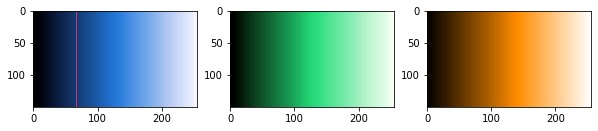

In [13]:
print('CLUT shades')
plt.figure(figsize=(10,60))
plt.subplot(1,3,1)
plt.imshow(np.tile((c_clut[0][:,:]).astype(np.uint8),(150,1,1)))
plt.subplot(1,3,2)
plt.imshow(np.tile(clut_p[:,:,1],(150,1,1)))
plt.subplot(1,3,3)
plt.imshow(np.tile(clut_p[:,:,2],(150,1,1)))

CLUT type, shape, min and max values uint8 (256, 3, 3) 0 255
CLUT shades


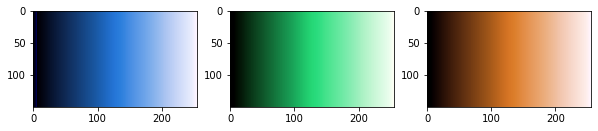

In [14]:
clut=loadmat('clutup1.mat')['CLUT'].astype(np.uint8)
print('CLUT type, shape, min and max values',clut.dtype,clut.shape,clut.min(),clut.max())
print('CLUT shades')
plt.figure(figsize=(10,60))
plt.subplot(1,3,1)
plt.imshow(np.tile(clut[:,:,0],(150,1,1)))
plt.subplot(1,3,2)
plt.imshow(np.tile(clut[:,:,1],(150,1,1)))
plt.subplot(1,3,3)
plt.imshow(np.tile(clut[:,:,2],(150,1,1)))

In [15]:
r,c=imfused.shape
res=np.zeros(f.shape+(3,))
res=np.array([[clut[imfused[i,j],:,choice_v1[i,j]] for j in range(c)] for i in range(r)])

print('Shape of the resultant image:',res.shape)

mask_res=(choice_v1*0.5).reshape(f.shape)

Shape of the resultant image: (512, 640, 3)


protoype pseudocolored image, mask from decision curve


/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


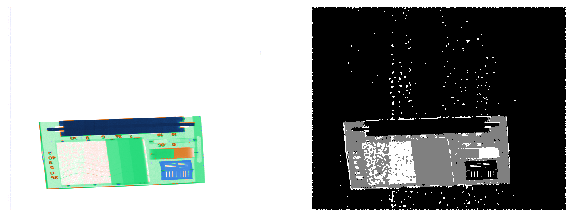

In [16]:
print('protoype pseudocolored image, mask from decision curve')
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1).axis('off')
fig.add_subplot(1,2,1).imshow(res)
fig.add_subplot(1,2,2).axis('off')
fig.add_subplot(1,2,2).imshow(mask_res,cmap='gray')

Ideal, Butterworth, Gaussian (L2R)


/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/user1/anaconda3/lib/python3.7/site-

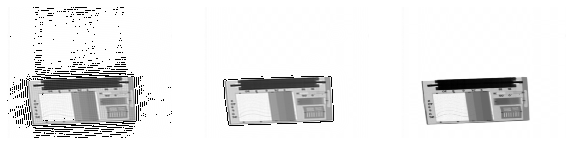

In [17]:

def lpfilter(filt_type,img):
    F=fft2(img)
    m,n=img.shape
    u,v=np.arange(m),np.arange(n)
    idx,idy=np.argwhere(u>m/2),np.argwhere(v>n/2)
    u[idx],v[idy]=u[idx]-m,v[idy]-n
    V,U=np.meshgrid(v,u)
    d,d0=np.hypot(V,U),0.12*n
    
    res_img={
        'ideal':
            ifft2(F*np.reshape((d<=d0).astype(np.uint8),F.shape)),
        'butterworth':
            ifft2(F*np.reshape(1/(1+(d/d0)**8),F.shape)),
        'gaussian':
            ifft2(F*np.reshape(np.exp(-d**2/(2*d0**2)),F.shape))
    }
    return res_img[filt_type].astype(np.uint8)

print('Ideal, Butterworth, Gaussian (L2R)')
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,3,1).axis('off')
fig.add_subplot(1,3,1).imshow(lpfilter('ideal',imfused),cmap='gray')
fig.add_subplot(1,3,2).axis('off')
fig.add_subplot(1,3,2).imshow(lpfilter('butterworth',imfused),cmap='gray')
fig.add_subplot(1,3,3).axis('off')
fig.add_subplot(1,3,3).imshow(lpfilter('gaussian',imfused),cmap='gray')

Final Result


/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


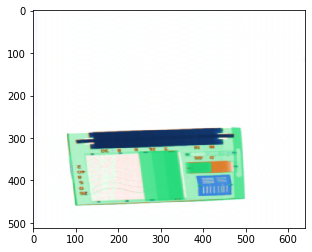

In [18]:
print('Final Result')
for i in range(3):
    res[:,:,i]=lpfilter('gaussian',res[:,:,i]);
plt.imshow(res)

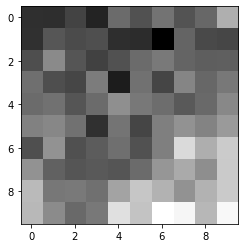

In [62]:
le_part = le[370:380, 390:400] 
plt.imshow(le_part, cmap='gray')

In [64]:
le_single_val = le[457, 371]
le_single_val

0.503374199699553

In [65]:
he_single_val = he[457, 371]
he_single_val

0.6010134416546986

In [66]:
c_small = np.log(le_single_val)
d_small = np.log(he_single_val)
print(c_small, d_small)

-0.686421449681059 -0.5091379792150055


In [68]:
R = c_small / d_small
print(R)

1.3482031938363568


In [69]:
zeff_part_small = 5.7*(R**2)-7.4*R+8
print(zeff_part_small)

8.383911921273112


In [59]:
le_part

array([[0.00104961, 0.00104762, 0.00112856, 0.00100493, 0.00128215,
        0.00118644, 0.00131126, 0.00119053, 0.001265  , 0.00154438],
       [0.00105752, 0.00120257, 0.00116002, 0.00117495, 0.00104909,
        0.00104512, 0.00086894, 0.00125603, 0.00114941, 0.00114071],
       [0.00117058, 0.00139975, 0.00119835, 0.00111949, 0.0011845 ,
        0.00128339, 0.00133985, 0.00125374, 0.0012308 , 0.00123577],
       [0.00129879, 0.00116976, 0.00113884, 0.00134568, 0.00097751,
        0.00130894, 0.00113661, 0.00138089, 0.00126688, 0.00133067],
       [0.00128042, 0.00131005, 0.00119638, 0.00127981, 0.00142097,
        0.00133072, 0.00129061, 0.00121336, 0.00127317, 0.00139306],
       [0.00136694, 0.00138771, 0.00130714, 0.00105468, 0.00131773,
        0.00113531, 0.00135749, 0.00143168, 0.00137898, 0.001463  ],
       [0.0011737 , 0.00143043, 0.00117805, 0.00122229, 0.00129598,
        0.00118255, 0.00135831, 0.00170892, 0.00153949, 0.00165158],
       [0.00143187, 0.00124718, 0.0011981

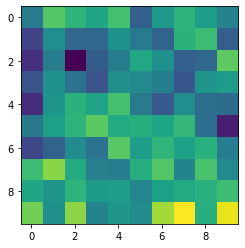

In [60]:
he_part = he[370:380, 390:400]
plt.imshow(he_part)

In [61]:
he_part

array([[0.48630018, 0.49286967, 0.49110584, 0.48990328, 0.49211414,
        0.48398576, 0.48881971, 0.49098851, 0.48914907, 0.48679974],
       [0.48195026, 0.48780356, 0.48447327, 0.48456739, 0.48822046,
        0.48625994, 0.48426656, 0.49089949, 0.49182629, 0.48388218],
       [0.48046792, 0.48641343, 0.47774114, 0.48379961, 0.48644815,
        0.49002464, 0.4880607 , 0.48401204, 0.48469378, 0.49314679],
       [0.48310423, 0.48808828, 0.48541679, 0.48300106, 0.48784725,
        0.48755325, 0.4865936 , 0.48331445, 0.48842344, 0.48911212],
       [0.48037175, 0.48853129, 0.49089754, 0.48971579, 0.49217964,
        0.48615307, 0.48348469, 0.48779746, 0.48517347, 0.48501856],
       [0.48605019, 0.48940762, 0.49109647, 0.49310414, 0.49035592,
        0.49067308, 0.48981194, 0.4913681 , 0.48521567, 0.47944055],
       [0.4822068 , 0.48423935, 0.48759762, 0.48554559, 0.49290851,
        0.48921379, 0.4912192 , 0.48944463, 0.49086332, 0.48654448],
       [0.49183387, 0.4945763 , 0.4903892

In [21]:
np.savetxt('le_part.txt', le_part)
np.savetxt('he_part.txt', he_part)

In [31]:
a = le_part.flatten()
b = he_part.flatten()

print(a.shape, b.shape)

(100,) (100,)


In [50]:
a

array([0.10496134, 0.10476155, 0.11285561, 0.10049334, 0.1282152 ,
       0.11864397, 0.13112573, 0.11905296, 0.1264998 , 0.15443811,
       0.10575217, 0.12025689, 0.11600184, 0.11749517, 0.10490892,
       0.10451214, 0.0868945 , 0.12560348, 0.11494095, 0.11407145,
       0.11705771, 0.13997513, 0.11983461, 0.11194922, 0.11844997,
       0.12833895, 0.13398523, 0.1253742 , 0.1230804 , 0.12357709,
       0.1298789 , 0.1169757 , 0.11388407, 0.1345678 , 0.09775079,
       0.13089415, 0.11366079, 0.13808909, 0.12668779, 0.1330673 ,
       0.12804249, 0.13100483, 0.11963761, 0.12798134, 0.14209711,
       0.13307193, 0.12906132, 0.12133584, 0.12731706, 0.13930594,
       0.13669422, 0.13877136, 0.13071356, 0.1054676 , 0.13177253,
       0.11353052, 0.13574868, 0.14316786, 0.13789774, 0.14629952,
       0.11737036, 0.14304287, 0.11780491, 0.12222902, 0.12959778,
       0.11825525, 0.13583132, 0.17089209, 0.15394866, 0.16515784,
       0.14318667, 0.12471783, 0.1198171 , 0.12180079, 0.11972

In [51]:
b

array([0.48630018, 0.49286967, 0.49110584, 0.48990328, 0.49211414,
       0.48398576, 0.48881971, 0.49098851, 0.48914907, 0.48679974,
       0.48195026, 0.48780356, 0.48447327, 0.48456739, 0.48822046,
       0.48625994, 0.48426656, 0.49089949, 0.49182629, 0.48388218,
       0.48046792, 0.48641343, 0.47774114, 0.48379961, 0.48644815,
       0.49002464, 0.4880607 , 0.48401204, 0.48469378, 0.49314679,
       0.48310423, 0.48808828, 0.48541679, 0.48300106, 0.48784725,
       0.48755325, 0.4865936 , 0.48331445, 0.48842344, 0.48911212,
       0.48037175, 0.48853129, 0.49089754, 0.48971579, 0.49217964,
       0.48615307, 0.48348469, 0.48779746, 0.48517347, 0.48501856,
       0.48605019, 0.48940762, 0.49109647, 0.49310414, 0.49035592,
       0.49067308, 0.48981194, 0.4913681 , 0.48521567, 0.47944055,
       0.4822068 , 0.48423935, 0.48759762, 0.48554559, 0.49290851,
       0.48921379, 0.4912192 , 0.48944463, 0.49086332, 0.48654448,
       0.49183387, 0.4945763 , 0.49038928, 0.48667366, 0.48640

In [55]:
c = np.log(a)
d = np.log(b)

np.savetxt('c.txt', c)
np.savetxt('d.txt', d)

R = c / d

np.savetxt('R.txt', R)

In [56]:
c

array([-2.25416316, -2.25606846, -2.1816461 , -2.2976638 , -2.05404518,
       -2.13162812, -2.03159865, -2.12818682, -2.06751452, -1.86796183,
       -2.24665696, -2.11812506, -2.15414919, -2.14135807, -2.25466276,
       -2.25845208, -2.44306059, -2.07462531, -2.1633368 , -2.17093031,
       -2.14508822, -1.96629051, -2.12164273, -2.18970994, -2.13326458,
       -2.05308046, -2.01002569, -2.07645242, -2.09491745, -2.09089014,
       -2.04115281, -2.14578908, -2.17257425, -2.00568712, -2.32533398,
       -2.0333663 , -2.17453679, -1.97985619, -2.06602959, -2.01690027,
       -2.05539309, -2.03252112, -2.12328806, -2.05587081, -1.95124458,
       -2.01686551, -2.04746766, -2.10919307, -2.06107479, -1.97108273,
       -1.99000883, -1.97492762, -2.03474691, -2.24935147, -2.02667808,
       -2.17568355, -1.99695007, -1.94373752, -1.98124291, -1.92209923,
       -2.1424209 , -1.94461092, -2.13872533, -2.10185881, -2.04331959,
       -2.13490985, -1.99634144, -1.76672298, -1.87113613, -1.80

In [57]:
d

array([-0.72092919, -0.7075105 , -0.7110956 , -0.71354729, -0.70904459,
       -0.7256998 , -0.71576156, -0.71133455, -0.715088  , -0.71990245,
       -0.72991436, -0.71784249, -0.72469301, -0.72449877, -0.71698821,
       -0.72101194, -0.72511977, -0.71151587, -0.7096297 , -0.72591382,
       -0.73299482, -0.72069633, -0.73868625, -0.72608448, -0.72062496,
       -0.71329961, -0.7173155 , -0.72564549, -0.72423796, -0.70694841,
       -0.72752286, -0.71725898, -0.7227474 , -0.72773642, -0.71775294,
       -0.71835576, -0.72032601, -0.72708781, -0.71657254, -0.71516354,
       -0.73319499, -0.71635175, -0.71151985, -0.71393007, -0.7089115 ,
       -0.72123174, -0.72673562, -0.71785501, -0.72324879, -0.72356813,
       -0.72144339, -0.71455957, -0.71111469, -0.7070349 , -0.71262378,
       -0.7119772 , -0.71373376, -0.71056173, -0.72316181, -0.73513537,
       -0.72938221, -0.72517598, -0.71826477, -0.72248209, -0.70743171,
       -0.71495568, -0.71086481, -0.71448394, -0.71158956, -0.72

In [44]:
R

array([3.12674697, 3.18874201, 3.06800673, 3.22005822, 2.8969196 ,
       2.93734148, 2.83837352, 2.99182265, 2.89127286, 2.59474298,
       3.07797336, 2.95068222, 2.9724989 , 2.95564071, 3.14463016,
       3.13233658, 3.36918214, 2.91578218, 3.04854322, 2.99061712,
       2.92647119, 2.72832041, 2.87218386, 3.01577845, 2.96029792,
       2.87828625, 2.80215008, 2.86152462, 2.89258167, 2.95762763,
       2.80562018, 2.99165175, 3.00599386, 2.75606258, 3.23974148,
       2.83058399, 3.01882308, 2.72299462, 2.88321067, 2.82019448,
       2.80333761, 2.83732275, 2.98415857, 2.87965291, 2.7524516 ,
       2.79641813, 2.81734869, 2.93818815, 2.84974523, 2.72411491,
       2.75837142, 2.76383904, 2.86134843, 3.18138676, 2.84396638,
       3.05583319, 2.79789213, 2.73549422, 2.73969515, 2.61461944,
       2.93730896, 2.68157108, 2.97762805, 2.90921927, 2.88836303,
       2.986073  , 2.80832783, 2.47272596, 2.62951599, 2.4997033 ,
       2.73896136, 2.95673618, 2.97771627, 2.92346718, 2.94502

In [33]:
# for x in R:
#     if x > 5:
#         print(x)
        
np.max(R)

3.3691821437285507

In [37]:
zeff = 5.7*(R**2)-7.4*R+8
np.savetxt('zeff.txt', zeff)
zeff1 = np.reshape(zeff, le_part.shape)

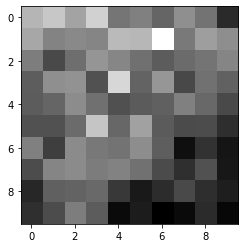

In [38]:
plt.imshow(zeff1, cmap='gray')

In [42]:
zeff1_part = zeff1

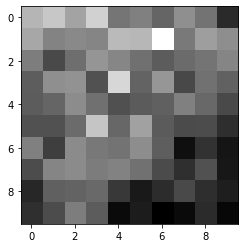

In [45]:
plt.imshow(zeff1_part, cmap='gray')

In [46]:
np.mean(zeff1_part)

33.05678037249209

In [47]:
zeff1_part

array([[40.58838805, 42.36133999, 38.94894241, 43.2735863 , 34.39801101,
        35.44313034, 32.91731211, 36.8812281 , 34.25349567, 27.17524134],
       [39.22434117, 35.7921472 , 36.36728144, 35.92238721, 41.09532019,
        40.74644426, 47.77096555, 34.8833904 , 38.4143899 , 36.84904076],
       [35.16024474, 30.23970288, 33.76764826, 37.52428165, 36.04496879,
        33.92251257, 32.02074636, 33.49815972, 34.28695932, 35.97465443],
       [32.10598695, 36.87666413, 37.26084031, 30.90165822, 43.85268468,
        32.72325104, 37.60647812, 30.11362814, 34.04779253, 32.46549324],
       [32.04990165, 32.89109375, 36.67688   , 33.95725357, 30.81499996,
        31.88024568, 32.39510555, 35.46522043, 33.20185811, 30.14012131],
       [30.95714502, 31.08878668, 33.49371626, 42.14870184, 33.05707399,
        38.61409829, 31.9163403 , 30.41003594, 30.5100541 , 27.61835459],
       [35.44228204, 29.14406762, 36.50328467, 34.71405082, 34.17916719,
        36.72786206, 32.17259373, 24.5537579 